## HDBSCAN

In [ ]:
!pip install hdbscan
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from hdbscan import HDBSCAN,prediction
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


## Reading Data

In [ ]:
# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Remove the 'Unnamed: 0' column from train and test datasets
if 'Unnamed: 0' in train.columns:
    train = train.drop(columns=['Unnamed: 0'])

if 'Unnamed: 0' in test.columns:
    test = test.drop(columns=['Unnamed: 0'])

# Confirm removal by printing column names
print("Training Data Columns:", train.columns)
print("Testing Data Columns:", test.columns)

Training Data Columns: Index(['Policy_start_date', 'Age', 'Annual_premium', 'Vehicle_year',
       'Claim_amount', 'Vehicle_risk_type', 'Area'],
      dtype='object')
Testing Data Columns: Index(['Policy_start_date', 'Age', 'Annual_premium', 'Vehicle_year',
       'Claim_amount', 'Vehicle_risk_type', 'Area', 'fraud_reported'],
      dtype='object')


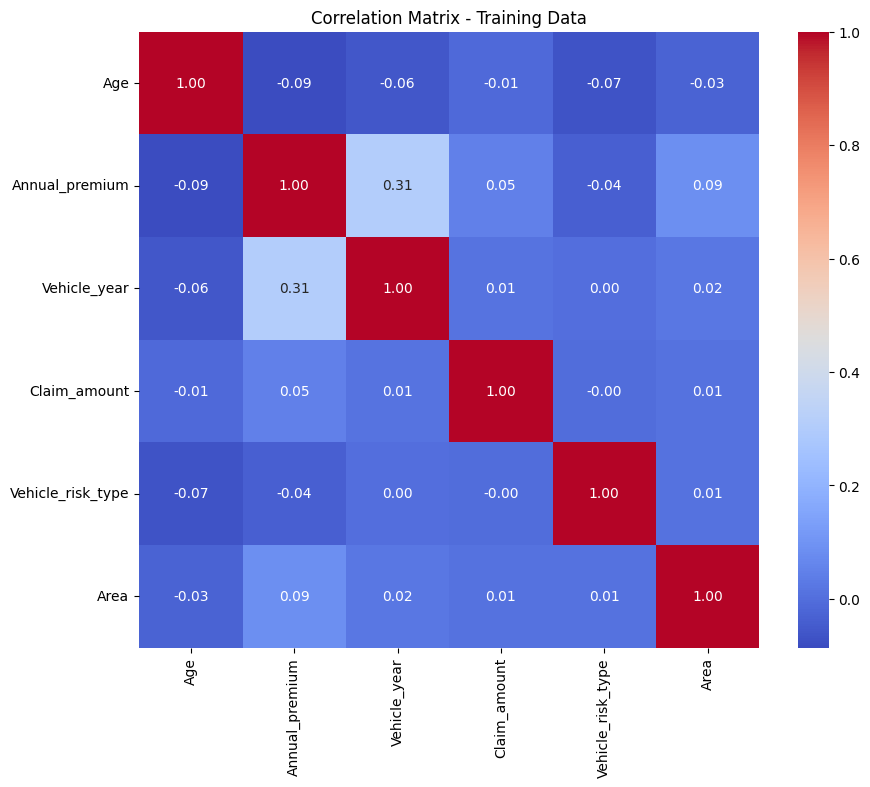

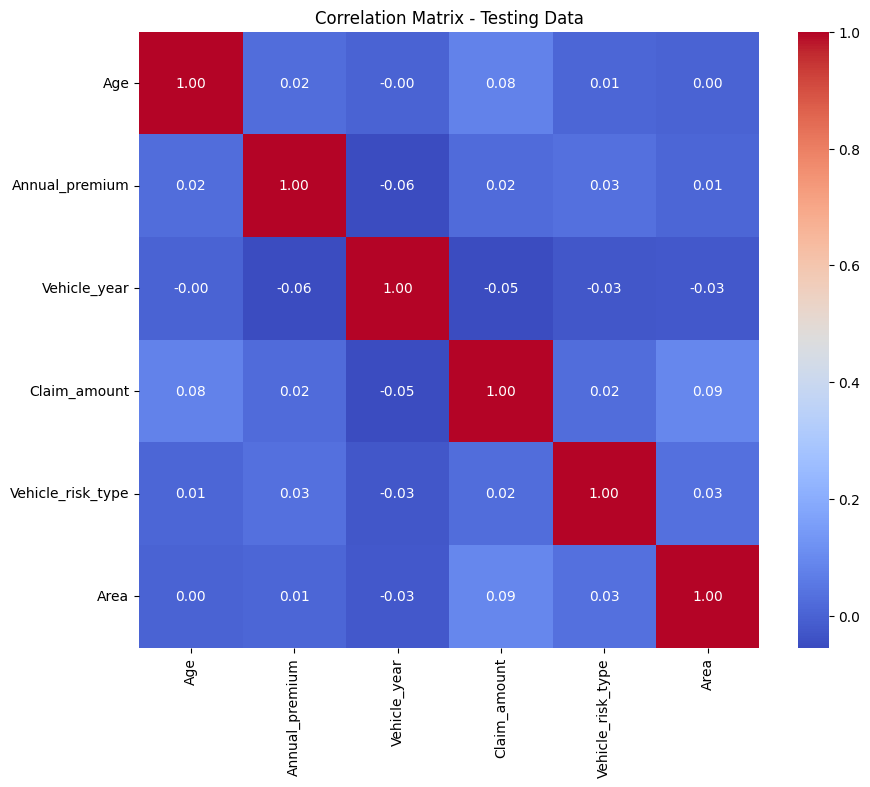

In [ ]:
# Select numerical features for correlation calculation
train_numerical = train.select_dtypes(include=['float64', 'int64'])
test_numerical = test.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrices
train_corr = train_numerical.corr()
test_corr = test_numerical.corr()

# Plot correlation for the training data
plt.figure(figsize=(10, 8))
sns.heatmap(train_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Matrix - Training Data')
plt.show()

# Plot correlation for the testing data
plt.figure(figsize=(10, 8))
sns.heatmap(test_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Correlation Matrix - Testing Data')
plt.show()

<ipython-input-10-4e8ff7aae8b5>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


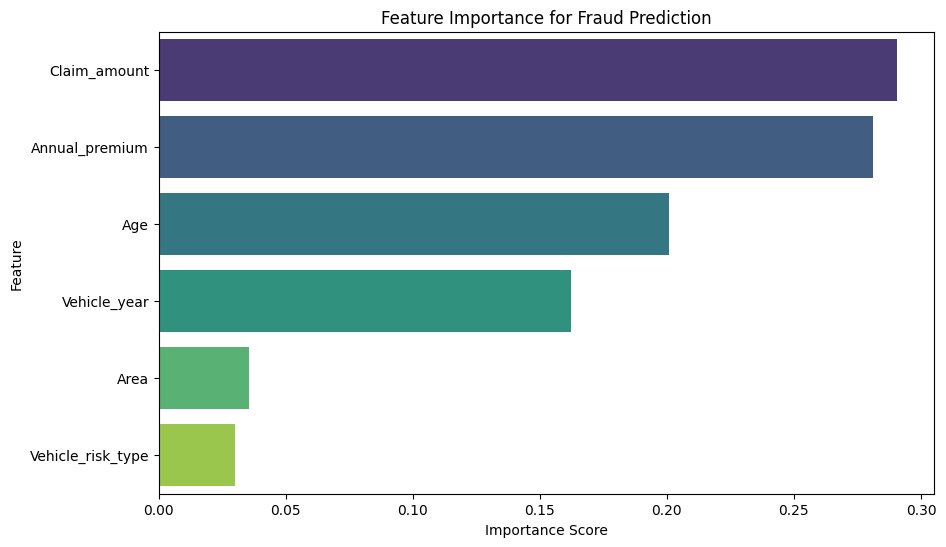

In [ ]:
# Preprocess test data for fraud prediction
# Encode categorical variables
label_encoder = LabelEncoder()
if 'fraud_reported' in test.columns:
    test['fraud_reported'] = label_encoder.fit_transform(test['fraud_reported'])  # Y=1, N=0

# Define features and target
features = ['Age', 'Annual_premium', 'Vehicle_year', 'Claim_amount', 'Vehicle_risk_type', 'Area']
target = 'fraud_reported'

# Standardize numerical features
scaler = StandardScaler()
test[features] = scaler.fit_transform(test[features])

# Train a Random Forest model on the test set
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(test[features], test[target])

# Get feature importance
feature_importances = rf_model.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Feature Importance for Fraud Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

## Data Preprocessing

In [ ]:
# Preprocessing function
def preprocess_data(data):
    # Convert categorical columns to numerical using LabelEncoder
    label_encoders = {}
    categorical_columns = ['Vehicle_risk_type', 'Area']

    for col in categorical_columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le

    # Convert Policy_start_date to numerical values (days since the earliest date)
    data['Policy_start_date'] = pd.to_datetime(data['Policy_start_date'], format='%Y-%m-%d', errors='coerce')
    data['Policy_start_date'] = (data['Policy_start_date'] - data['Policy_start_date'].min()).dt.days

    return data, label_encoders

# Preprocess the train and test datasets
train, train_label_encoders = preprocess_data(train)
test, test_label_encoders = preprocess_data(test)




In [ ]:
train.head()

,Unnamed: 0,Policy_start_date,Age,Annual_premium,Vehicle_year,Claim_amount,Vehicle_risk_type,Area
0,1,12088,38,380.20,2013,0.0,1,0
1,2,12088,38,393.50,2013,0.0,1,0
2,3,12088,38,393.50,2013,0.0,1,0
3,4,12088,38,395.47,2013,0.0,1,0
4,5,9347,39,250.52,2006,0.0,1,0


In [ ]:
test.head()

,Unnamed: 0,Policy_start_date,Age,Annual_premium,Vehicle_year,Claim_amount,Vehicle_risk_type,Area,fraud_reported
0,1,9048,48,1406.91,2004,71610,1,1,Y
1,2,6014,42,1197.22,2007,5070,1,1,Y
2,3,3894,29,1413.14,2007,34650,2,1,N
3,4,137,41,1415.74,2014,63400,1,1,Y
4,5,8915,44,1583.91,2009,6500,1,1,N


## Data Standardizing

In [ ]:
# Features to be used for clustering
features_to_use = ['Policy_start_date', 'Age', 'Annual_premium', 'Vehicle_year', 'Claim_amount', 'Vehicle_risk_type', 'Area']


# Scale features
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[features_to_use])
test_scaled = scaler.transform(test[features_to_use])


In [ ]:
# Count 'fraud_reported' occurrences as 'Yes' and 'No'
fraud_counts = test['fraud_reported'].value_counts()

# Create a DataFrame for a better representation
fraud_counts_table = pd.DataFrame({
    'Fraud Reported': fraud_counts.index,
    'Count': fraud_counts.values
})

# Rename columns for clarity
fraud_counts_table.columns = ['Fraud Reported', 'Count']

# Display the table
print(fraud_counts_table)

  Fraud Reported  Count
0              N    762
1              Y    253


## Model Training

In [ ]:
# Train HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=50, metric='euclidean', prediction_data=True)
hdbscan_model.fit(train_scaled)

HDBSCAN(min_cluster_size=50, prediction_data=True)

## Model Testing

In [ ]:
# Assign clusters to test data
test['cluster'] = prediction.approximate_predict(hdbscan_model, test_scaled)[0]

# Map clusters to the majority fraud label from the test data
test['fraud_reported_numeric'] = LabelEncoder().fit_transform(test['fraud_reported'])  # Convert fraud_reported to 0/1
cluster_mapping = test.groupby('cluster')['fraud_reported_numeric'].apply(lambda x: x.mode()[0]).to_dict()

# Predict fraud based on clusters
test['predicted_fraud'] = test['cluster'].map(cluster_mapping)

# Evaluate the model
accuracy = accuracy_score(test['fraud_reported_numeric'], test['predicted_fraud'])
conf_matrix = confusion_matrix(test['fraud_reported_numeric'], test['predicted_fraud'])

# Output results
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.7507389162561576
Confusion Matrix:
 [[762   0]
 [253   0]]


## Visualizations

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
train_reduced = pca.fit_transform(train_scaled)
test_reduced = pca.transform(test_scaled)

# Prepare data for plotting
train_plot_data = pd.DataFrame({
    'PCA1': train_reduced[:, 0],
    'PCA2': train_reduced[:, 1],
    'Cluster': hdbscan_model.labels_
})

test_plot_data = pd.DataFrame({
    'PCA1': test_reduced[:, 0],
    'PCA2': test_reduced[:, 1],
    'Cluster': prediction.approximate_predict(hdbscan_model, test_scaled)[0],
    'Fraud': test['fraud_reported']
})

# Combine train and test for a unified plot
train_plot_data['Dataset'] = 'Train'
test_plot_data['Dataset'] = 'Test'
combined_plot_data = pd.concat([train_plot_data, test_plot_data], ignore_index=True)

# Create scatter plot
fig = px.scatter(
    combined_plot_data,
    x='PCA1',
    y='PCA2',
    color=combined_plot_data['Cluster'].astype(str),
    facet_col='Dataset',
    title='HDBSCAN Clustering Results: Train vs Test',
    labels={'Cluster': 'Cluster Label'},
    color_discrete_sequence=px.colors.qualitative.Set3
)

# Update layout
fig.update_layout(
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    legend_title_text='Clusters',
    plot_bgcolor="white",
    paper_bgcolor="white",
    font=dict(color="black")
)

fig.update_traces(marker=dict(size=6, opacity=0.8))

# Show the plot
fig.show()

In [ ]:
# Add fraud labels to the plot data
test_plot_data['Fraud'] = test['fraud_reported']

# Plot clusters and fraud labels
fig = px.scatter(
    test_plot_data,
    x='PCA1',
    y='PCA2',
    color='Fraud',  # Use fraud labels for coloring
    symbol='Cluster',  # Different symbols for clusters
    title='Fraud vs Non-Fraud in Test Data Clusters',
    labels={'Fraud': 'Fraud Label', 'Cluster': 'Cluster'},
    color_discrete_map={'Y': 'red', 'N': 'blue'}
)
fig.show()

In [ ]:
# Count fraud and no fraud in each cluster
fraud_counts = test.groupby('cluster')['fraud_reported'].value_counts().unstack(fill_value=0)
print(fraud_counts)

fraud_reported    N    Y
cluster                 
-1              762  253
